# Autoregressive model using a feedforward neural network

In this notebook we will use a feedforward neural network to fit a linear model to time series data. 

<div class="alert alert-success">
    
1. The data preprocessing requirements for a NN are similar to those of an OLS.

2. Forecasting **h-steps** ahead can use either an iterative or direct method.
</div>

---
**LEARNING OBJECTIVES**

* Use a NN to mimic a linear model
* Generate h-step forecasts using an iterative approach
* Generate h-step forecast using a direct modelling approach
* Construct a deep neural network for forecasting

---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided for this work. We are going to implement neural networks using `tensorflow` and '`keras`. You should be using at least `tensorflow` version `2.1.0`.

In [82]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

tf.__version__

'2.1.0'

## 2. Reminder: The forecasting process for AR

1. Select $l$ the number of autoregressive lags and forecast horizon $h$
2. Preprocess the data into tabular form [[$lag_1, lag_2, ... lag_l$], [$y_t$]]
3. Train the NN model using the tabular data
4. Iteratively forecast 1-step ahead gradually replacing ground truth observations with predictions.


### 2.1 Synthetic data without noise

Given the extra complexities of forecasting using OLS we will use simple synthetic data before exploring real healthcare data. The synthetic data we wil use is a cosine.  

In [6]:
t = np.arange(200)
ts_data = np.cos(0.2 * t)

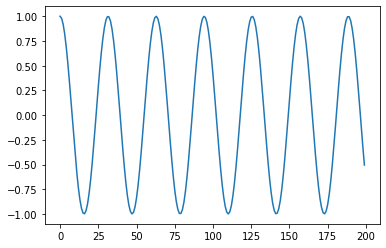

In [7]:
plt.plot(ts_data);

## 2.2. Preprocess the time series into tabular autoregressive form

An autoregressive model consists of $l$ lags of the time series. 

An easy way to think about the form of the data for a autoregressive OLS model is as a table of variables.  The first $l$ columns are the lags (the independent predictor variables) and the final column is $y$ at time $t$ ($y_t$) that is, the target/dependent variable.  

We there need to manipulate the time series so that is now in that format.  More precisely for each row we need: 

**A vector presenting the lags at time t**
* $X_t = $ [$lag_{t-l}, ... lag_{t-2}, lag_{t-1}$]

**A scalar value representing y at time t:**
* $y_t$

For training we need a vector of rows ($X_t$) and vector of target $y_t$. e.g.

```python
X_train = [X_1, X_2, X_3, ...,  X_t]

y_train = [y_1, y_2, y_3, ..., y_t]
```
---

The function `sliding_window` illustrates how to preprocess time series data into tabular form  in python.

In [8]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.asarray(tabular_y).reshape(-1, )

In [9]:
#preprocess time series training and test sets
X_train, y_train = sliding_window(ts_data, window_size=2)

training_length = int(len(y_train) * (2/3))

X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]
print(X_train.shape, y_train.shape)

(131, 2) (131,)


<div class="alert alert-info">
    
If you need a reminder of what the preprocessing does to the data please look back to the OLS notebook.  Here is the result of the preprocessing as a **pandas.DataFrame**.  This looks just like cross-sectional data that you would use to train a conventional NN.
</div>



In [10]:
tabular_form = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
columns = [f'lag_{i}' for i in range(len(X_train[0]), 0, -1)]
columns.append('y_t')
tabular_form.columns = columns
tabular_form.head()

,lag_2,lag_1,y_t
0,1.000000,0.980067,0.921061
1,0.980067,0.921061,0.825336
2,0.921061,0.825336,0.696707
3,0.825336,0.696707,0.540302
4,0.696707,0.540302,0.362358


## 2.3 Train the NN using the preprocessed series

After preprocessing the data, fitting the data is relatively straightforward.  We create an instance of `OLS` passing in the training data and call the `.fit()` method.  The method fit returns a `RegressionResults` object that we use for prediction.  We can called the `.summary()` method to see the fitted model.

In [11]:
def get_linear_model(ws, lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mae', 'mse']
    
    model = Sequential([Dense(1, input_shape=(ws,))])
    model.compile(loss='mse', 
                  optimizer=Adam(lr=lr),
                  metrics=metrics)
    
    return model

In [14]:
N_EPOCHS = 100
WINDOW_SIZE = 5
es = EarlyStopping(monitor='val_loss', patience=3)

#pre-process the data into sliding windows
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

#train test split
training_length = int(len(y_train) * (2/3))
X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]

#compile the tf model
model = get_linear_model(WINDOW_SIZE)

history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[es])

Train on 129 samples, validate on 65 samples
Epoch 1/100
129/129 [==============================] - 0s 3ms/sample - loss: 0.0875 - mae: 0.2638 - mse: 0.0875 - val_loss: 0.0683 - val_mae: 0.2362 - val_mse: 0.0683
Epoch 2/100
129/129 [==============================] - 0s 780us/sample - loss: 0.0642 - mae: 0.2291 - mse: 0.0642 - val_loss: 0.0635 - val_mae: 0.2274 - val_mse: 0.0635
Epoch 3/100
129/129 [==============================] - 0s 624us/sample - loss: 0.0604 - mae: 0.2214 - mse: 0.0604 - val_loss: 0.0556 - val_mae: 0.2124 - val_mse: 0.0556
Epoch 4/100
129/129 [==============================] - 0s 640us/sample - loss: 0.0507 - mae: 0.2019 - mse: 0.0507 - val_loss: 0.0430 - val_mae: 0.1861 - val_mse: 0.0430
Epoch 5/100
129/129 [==============================] - 0s 320us/sample - loss: 0.0388 - mae: 0.1760 - mse: 0.0388 - val_loss: 0.0327 - val_mae: 0.1619 - val_mse: 0.0327
Epoch 6/100
129/129 [==============================] - 0s 239us/sample - loss: 0.0301 - mae: 0.1549 - mse: 0.030

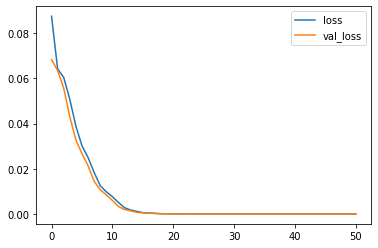

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## 2.4 Forecasting 1 step ahead

To forecast 1-step ahead we use the `RegressionResults` method `.predict(exog)`.  For example if we wanted to forecast the first y observation in the test set.

In [16]:
X_test[0]

array([0.78552098, 0.64691932, 0.48252703, 0.29889791, 0.10335267])

In [17]:
pred = model.predict(x=X_test[0].reshape(1, -1))[0,0]
print(f'1-step forecast: {pred}')
print(f'ground trust value: {y_test[0]}')

1-step forecast: -0.09631606936454773
ground trust value: -0.09631291684576058


## 2.4 Forecast h periods ahead using the iterative method.

**We have trained our `NN` model to predict 1-step**. When forecasting 2 or more steps ahead we still only have five ground truth observations ($lag_1$ ... $lag_5$). This means that when forecasting h-steps ahead we need to do this in a loop where we iteratively replace our ground truth observations with our predictions.

There's an easy way to do this in python using the `np.roll(a, shift)` function.  That shifts everything in the array down by `shift`.  The function is **circular** so the value in element 0 is moved to be the final value in the array.

In [18]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X.reshape(1, -1), 
                               use_multiprocessing=True)[0,0]
        y_preds.append(y_pred)

        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [19]:
H = 5
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
print(f'Iterative forecast: {y_preds}')
print(f'Ground truth y: {y_test[:H].T}')

Iterative forecast: [-0.09631607 -0.29214638 -0.47633263 -0.6415309  -0.7811556 ]
Ground truth y: [-0.09631292 -0.29213881 -0.47631805 -0.64150799 -0.78112303]


#### Adding some noise

To make this a bit more interesting we will add some normally distributed noise to the synthetic time series.

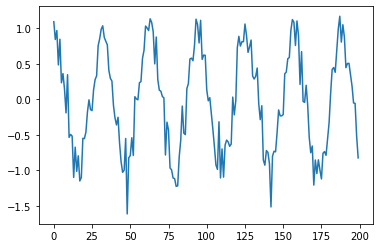

In [20]:
#set the random seed so that we all get the same results
np.random.seed(12)
t = np.arange(200)
ts_data = np.cos(0.2 * t)
noise = np.random.normal(loc=0.0, scale=0.2, size=200)
ts_data = ts_data + noise
plt.plot(ts_data);

In [21]:
#set tensorflow random seed
tf.random.set_seed(1234)

N_EPOCHS = 100
WINDOW_SIZE = 12
es = EarlyStopping(monitor='val_loss', patience=10)

#preprocess time series training and test sets
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

training_length = 130

#train-test split
X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]

#compile the tf model
model = get_linear_model(WINDOW_SIZE, metrics=['mse'], lr=0.001)

#fit model silently
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=None)

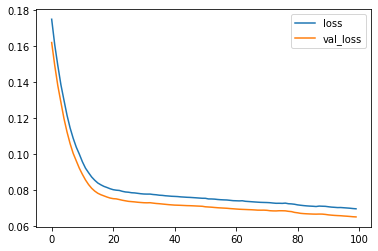

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

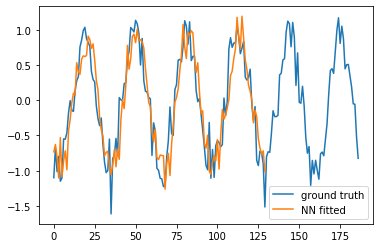

In [23]:
plt.plot(ts_data[WINDOW_SIZE+1:], label='ground truth')
plt.plot(model.predict(X_train), label='NN fitted')
plt.legend();

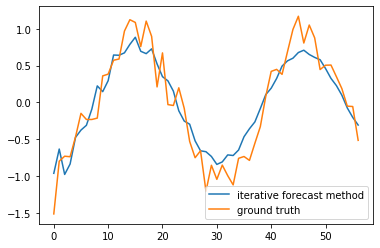

In [24]:
#make iterative predictions
H = len(y_test)
y_preds_iter = autoregressive_iterative_forecast(model, X_test[0], h=H)

#plot
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

##  The direct h-step forecasting method.

In the direct method to forecast h-steps ahead we have **$h$ forecasting models**.  Each model provides a single point forecast from a step ahead.  In the example here, y_test is of length 32 periods.  The direct method requires 32 NNs to make its prediction!


Recall the `sliding_window` function.  We ignored an optional parameter `horizon` in the iterative example.  By default `horizon=1` i.e. the function returns target values that are only a single period ahead.  We can vary the step size by increasing the value of horizon.  

**Training multiple models**

1. Create a for loop and set it to iterate 31 times. 
2. In each loop call `sliding_window` setting `horizon` to the iteration number + 1
3. Create a new instance of the the model
4. Train the model and save in a list.
5. Save the model to .h5 file. (recommended)

In [25]:
def train_direct_models(data, n_epochs, horizon, window_size, 
                        train_length, save=True):

    models = []

    print('Training model =>', end=' ')
    for h in range(HORIZON):
        print(f'{h+1}', end=', ')
        #preprocess time series training and test sets
        X_train, y_train = sliding_window(ts_data, 
                                          window_size=window_size, 
                                          horizon=h+1)

        #train-test split
        X_train, X_test = X_train[:train_length], X_train[train_length:]
        y_train, y_test = y_train[:train_length], y_train[train_length:]

        #compile the tf model
        model_h = get_linear_model(window_size, metrics=['mse'], lr=0.001)

    
        #fit model silently (verbose=0)
        history_h = model_h.fit(x=X_train, 
                            y=y_train, 
                            epochs=n_epochs,
                            verbose=0)
        
        if save:
            model_h.save(f'./output/direct_model_h{h+1}.h5')

        models.append(model_h)

    print('done')
    return models

In [26]:
def load_models(horizon):
    models = []
    for h in range(HORIZON):
        model_h = tf.keras.models.load_model(f'output/direct_model_h{h+1}.h5')
        models.append(model_h)
    return models

In [27]:
 #set tensorflow random seed
tf.random.set_seed(42)

N_EPOCHS = 100
HORIZON = len(y_test)
WINDOW_SIZE = 12
TRAIN_LENGTH = 130
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    direct_models = load_models(HORIZON)
else:
    direct_models = train_direct_models(ts_data, 
                                        n_epochs=N_EPOCHS,
                                        horizon=HORIZON, 
                                        window_size=WINDOW_SIZE, 
                                        train_length=TRAIN_LENGTH)

We now create the `direct_forecast` function.  This is just a for loop to call the `.predict()` method of each model.  Remember that the input to each model is **same** i.e. exog which in our case will be `X_test[0]`

In [28]:
def direct_forecast(models, exog):
    '''
    h-step forecast for an autoregressive 
    model using the direct prediction method.
    
    Each model contained in @models has been trained
    to predict a unique number of steps ahead. 
    Each model forecasts and the results are 
    combined in an ordered array and returned.
    
    Parameters:
    ------
    models: list
        direct models each has has a .predict(exog) 
        interface
        
    exog: array-like
        initial vector of lagged values (X)
        
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    preds = []
    for model_h in models:
        pred_h = model_h.predict(x=exog.reshape(1, -1), 
                                 use_multiprocessing=True)[0, 0]
        preds.append(pred_h)
    
    return np.array(preds)

In [29]:
#make the direct forecast
y_preds_direct = direct_forecast(direct_models, X_test[0])

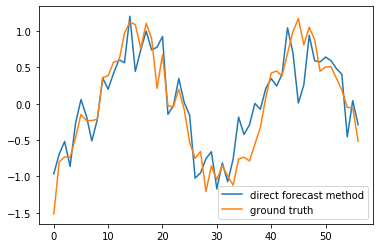

In [30]:
#for clarity repeat the preprocessing
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

#train-test split
X_train, X_test = X_train[:TRAIN_LENGTH], X_train[TRAIN_LENGTH:]
y_train, y_test = y_train[:TRAIN_LENGTH], y_train[TRAIN_LENGTH:]

#plot the direct forecast against the test data
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

Like the iterative method the direct method looks a close match to the ground truth test set!  Let's plot all three datasets on the same chart and then take a look at the **RMSE** of each method.

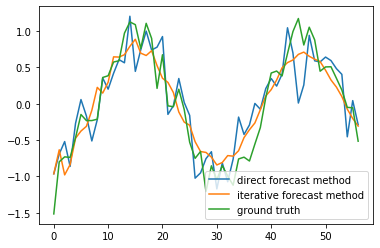

In [31]:
#plot iterative and direct
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

In [32]:
from statsmodels.tools.eval_measures import rmse

In [33]:
rmse(y_test, y_preds_iter)

0.2532784783778647

In [34]:
rmse(y_test, y_preds_direct)

0.3175379038168916

In this particular example (and single holdout set) the iterative method out performed the direct method. You should not assume this is always the case!

## Emergency admissions data

In [35]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/data/master/em_admits_ts.csv'
em_admits = pd.read_csv(url)

In [36]:
em_admits.head(3)

,month_year,em_admits
0,Aug-10,425702
1,Sep-10,424900
2,Oct-10,436215


In [37]:
em_admits.shape

(111, 2)

In [38]:
date_str = em_admits['month_year'].str[:3] + ' 20' + em_admits['month_year'].str[-2:]
date_str.name = 'date'
em_admits = em_admits.set_index(pd.to_datetime(date_str))
em_admits = em_admits.drop(columns=['month_year'])

In [39]:
em_admits.index.freq = 'MS'
em_admits.head()

,em_admits
date,
2010-08-01,425702
2010-09-01,424900
2010-10-01,436215
2010-11-01,429099
2010-12-01,452728


In [40]:
train, test = em_admits[:len(em_admits)-12], em_admits[len(em_admits)-12:]

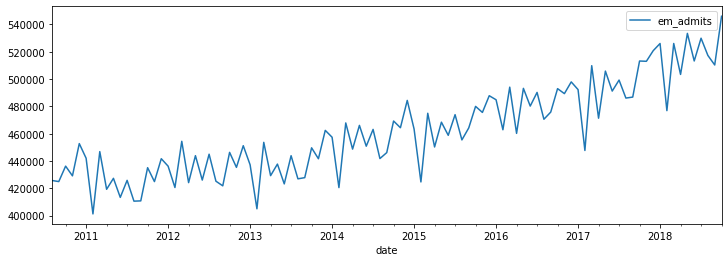

In [41]:
train.plot(figsize=(12,4))

In [42]:
#for clarity repeat the preprocessing
X_train, y_train = sliding_window(em_admits['em_admits'], window_size=12)

In [43]:
test_length = 12
X_train, y_train = X_train[:len(X_train) - 12], y_train[:len(X_train) - 12]
X_test, y_test = X_train[len(X_train) - 12:], y_train[len(X_train) - 12:]

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [46]:
scaler.fit(em_admits['em_admits'].iloc[:-12].to_numpy().reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [47]:
y_train = scaler.transform(y_train.reshape(-1, 1))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test.reshape(-1, 1))

In [100]:
#set tensorflow random seed
tf.random.set_seed(1234)

N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=10)

#compile the tf model
model = get_linear_model(WINDOW_SIZE, metrics=['mae'])

#fit model silently
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[es])

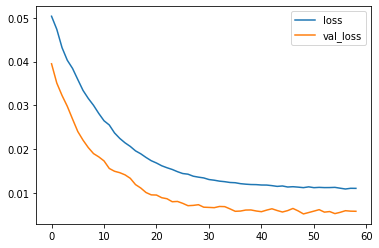

In [101]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

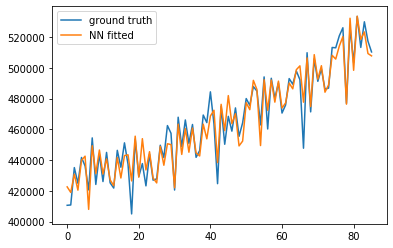

In [102]:
plt.plot(scaler.inverse_transform(y_train), label='ground truth')
plt.plot(scaler.inverse_transform(model.predict(X_train)), label='NN fitted')
plt.legend();

(86,)
(24, 1)


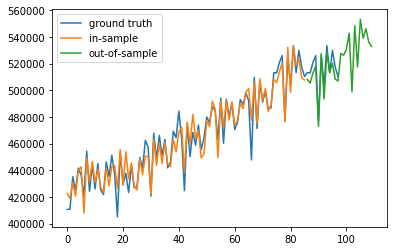

In [138]:
#predict next 12 months and plot
H = 12
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
y_preds = scaler.inverse_transform(y_preds.reshape(-1, 1))
    
fitted_values = scaler.inverse_transform(model.predict(X_train))
ground_truth = np.concatenate([scaler.inverse_transform(y_train), 
                               scaler.inverse_transform(y_test)])
nn = np.concatenate([fitted_values, y_preds])   

padding = np.full(len(fitted_values), np.NAN)
print(padding.shape)
print(y_preds.shape)

forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

plt.plot(ground_truth, label='ground truth')
plt.plot(fitted_values, label='in-sample')
plt.plot(forecast, label='out-of-sample')
plt.legend();

In [140]:
def get_network_model(ws, neurons=32, lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mae', 'mse']
        
    model = Sequential()
    model.add(Flatten(input_shape=(ws,)))
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', 
                  optimizer=Adam(lr=lr),
                  metrics=metrics)
    
    return model

In [142]:
#set tensorflow random seed
#tf.random.set_seed(45676)

N_EPOCHS = 100
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(12, neurons=200, metrics=['mse'])

#fit model silently
history = mlp.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    verbose=0, callbacks=[es])

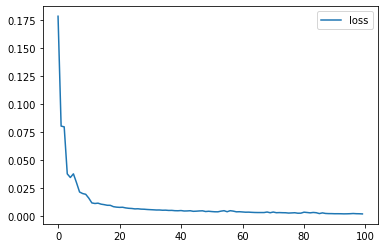

In [143]:
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

(86,)
(24, 1)


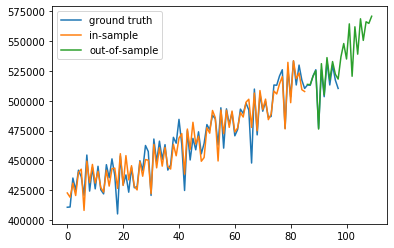

In [145]:
#predict next 12 months and plot
H = 24
y_preds = autoregressive_iterative_forecast(mlp, X_test[0], h=H)
y_preds = scaler.inverse_transform(y_preds.reshape(-1, 1))
    
fitted_values = scaler.inverse_transform(model.predict(X_train))
ground_truth = np.concatenate([scaler.inverse_transform(y_train), 
                               scaler.inverse_transform(y_test)])
nn = np.concatenate([fitted_values, y_preds])   

padding = np.full(len(fitted_values), np.NAN)
print(padding.shape)
print(y_preds.shape)

forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

plt.plot(ground_truth, label='ground truth')
plt.plot(fitted_values, label='in-sample')
plt.plot(forecast, label='out-of-sample')
plt.legend();